In [1]:
from categoriesDef import categories
version = 'v0'

### Imports

In [2]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle, yaml
import time
from array import array
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, DSetLoader
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass

In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Combine calibrations

In [6]:
categories

{'high': <categoriesDef.Bauble instance at 0x7f966e7f2c68>,
 'low': <categoriesDef.Bauble instance at 0x7f966e7f20e0>,
 'mid': <categoriesDef.Bauble instance at 0x7f966e7f2c20>,
 'single': <categoriesDef.Bauble instance at 0x7f966e7f2e60>}

In [7]:
dicRatios = {}
template = '../data/calibration/B0pTspectrum/RatioPtSpectrum_data_over_MC_{}.pkl'
for n, cat in categories.iteritems():
    if n == 'single':
        continue
    dicRatios[cat.name] = pickle.load(open(template.format(cat.name), 'rb'))

(0, 100)

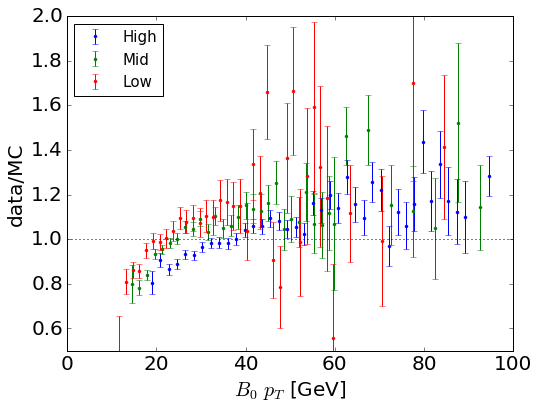

In [8]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))

for n, dic in dicRatios.iteritems():
    plt.errorbar(dic['pt'], dic['w'], yerr=dic['w_err'], fmt='.', label=n)

# plt.plot(dic['pt'], np.polyval(beta, dic['pt']), '-', color='#1f77b4', label='w, Central')
# colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# for i in range(len(betaVar)):
#     yP = np.polyval(beta+betaVar[i], dic['pt'])
#     yM = np.polyval(beta-betaVar[i], dic['pt'])
#     plt.plot(dic['pt'], yP, '--', color=colors[i], label='w, $\lambda_{} \pm 1\sigma$'.format(i))
#     plt.plot(dic['pt'], yM, '--', color=colors[i])
    
plt.plot([0,100] , [1,1], ':k')
plt.legend(loc='best', numpoints=1, fontsize=15)
plt.xlabel('$B_0\ p_T$ [GeV]')
plt.ylabel('data/MC')
plt.ylim(0.5, 2)
plt.xlim(0, 100)

In [9]:
x = []
y = []
yerr = []
for n, dic in dicRatios.iteritems():
    x += list(dic['pt'])
    y += list(dic['w'])
    yerr += list(dic['w_err'])
    
x = np.array(x)
y = np.array(y)
yerr = np.array(yerr)


Chi2/dof = 225.84/110 (0.0%)


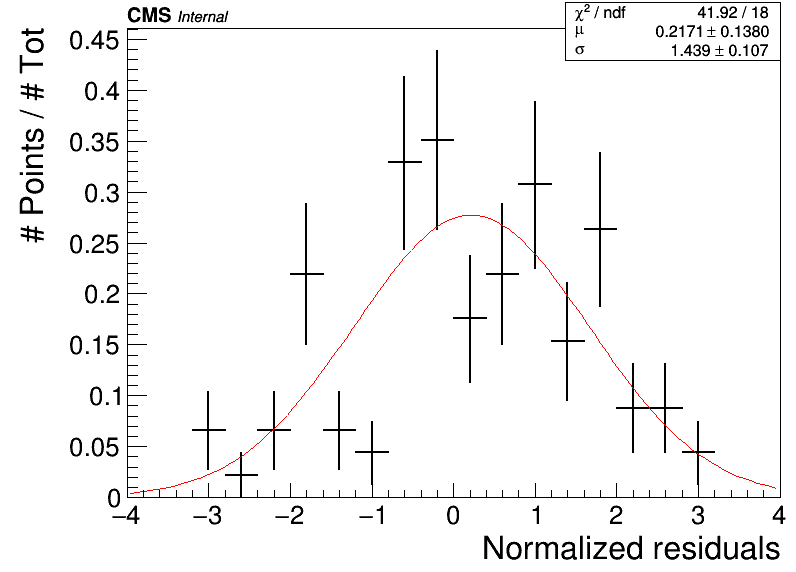

In [11]:
deg = 3

beta, covBeta = np.polyfit(x, y, deg=deg, full=False, w=1./yerr, cov='unscaled')

res = (y - np.polyval(beta, x))/yerr

chi2stat = np.sum(np.square(res))
dof = res.shape[0]-deg-1
pval = 1 - sps.chi2.cdf(chi2stat, df=dof)
print '\nChi2/dof = {:.2f}/{:.0f} ({:.1f}%)'.format(chi2stat, dof, 100*pval)

h = create_TH1D(res, binning=[20, -4,4],
                axis_title=['Normalized residuals', '# Points / # Tot'],
                scale_histo='norm'
               )
h.Scale(1./h.GetBinWidth(2))

fGaus = rt.TF1('fFit', 'exp(-(x-[0])*(x-[0])/(2*[1]*[1]))/({:.4f}*[1])'.format(np.sqrt(2*np.pi)), -5, 5)
fGaus.SetParameters(0,1)
fGaus.SetParNames('#mu','#sigma')
h.Fit(fGaus, 'QWL')
cResiduals = drawOnCMSCanvas(CMS_lumi, [h], ['E'], tag='residuals')

In [12]:
eigVal, eigVec = np.linalg.eig(covBeta)
eigSig = np.sqrt(eigVal)

print 'Beta:  '+', '.join(beta.shape[0]*['{:1.2e}']).format(*beta)
print 'Error: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*np.sqrt(np.diag(covBeta)))

betaVar = []
for i in range(eigSig.shape[0]):
    print '\n'
    betaVar.append(eigSig[i]*eigVec[:, i])
    print 'eigSigma: {:1.2e}'.format(eigSig[i])
    print 'eigVect: '+', '.join(beta.shape[0]*['{:.2f}']).format(*eigVec[:, i])
    print 'Variation: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*betaVar[i])
    
dOut = {
    'beta': beta,
    'betaVar' : betaVar
}

Beta:  8.60e-07, -1.98e-04, 1.69e-02, 6.46e-01
Error: 5.92e-07, 9.71e-05, 4.59e-03, 6.34e-02


eigSigma: 6.35e-02
eigVect: 0.00, -0.00, 0.07, -1.00
Variation: 5.18e-07, -9.05e-05, 4.50e-03, -6.34e-02


eigSigma: 9.22e-04
eigVect: -0.00, 0.04, -1.00, -0.07
Variation: -2.57e-07, 3.39e-05, -9.19e-04, -6.53e-05


eigSigma: 4.77e-08
eigVect: -1.00, -0.01, -0.00, -0.00
Variation: -4.77e-08, -5.94e-10, -8.55e-12, -1.49e-13


eigSigma: 9.64e-06
eigVect: -0.01, 1.00, 0.04, 0.00
Variation: -1.20e-07, 9.63e-06, 3.55e-07, 1.14e-08


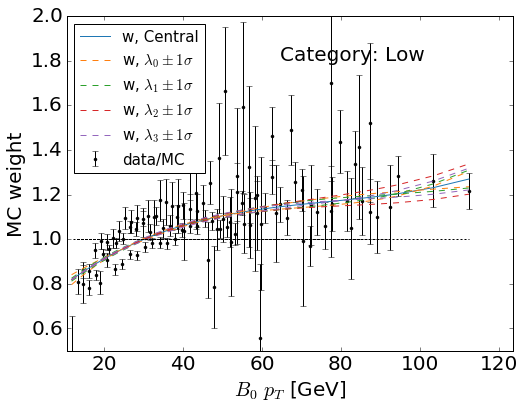

In [16]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=yerr, fmt='.k', label='data/MC')

xs = np.sort(x)
plt.plot(xs, np.polyval(beta, xs), '-', color='#1f77b4', label='w, Central')

colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i in range(len(betaVar)):
    yP = np.polyval(beta+betaVar[i], xs)
    yM = np.polyval(beta-betaVar[i], xs)
    plt.plot(xs, yP, '--', color=colors[i], label='w, $\lambda_{} \pm 1\sigma$'.format(i))
    plt.plot(xs, yM, '--', color=colors[i])
    
plt.plot(x , [1]*len(x), ':k')
plt.legend(loc='best', numpoints=1, fontsize=15)
plt.xlabel('$B_0\ p_T$ [GeV]')
plt.ylabel('MC weight')
_, ymax = plt.ylim(0.5, 2)
plt.xlim(0.9*np.min(x), 1.1*np.max(x))
plt.text(0.9*np.max(x) ,ymax*0.9, 'Category: ' + cat.name, horizontalalignment='right')

In [ ]:
raise

# Load data

In [ ]:
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2JpsiKst_200622*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
if not lumi_tot:
    expectedLumi = {'Low':6.4, 'Mid':20., 'High':26.} #fb^-1
    lumi_tot = expectedLumi[cat.name]
    print 'Total lumi (estimated): {:.1f} fb^-1'.format(lumi_tot)
CMS_lumi.integrated_lumi = lumi_tot

In [ ]:
for cat in categories:
    dsetRD_loc = '../data/cmsRD/skimmed/B2JpsiKst_200622_{}_corr_sw.root'.format(cat.name)
    dfRD = pd.DataFrame(rtnp.root2array(dsetRD_loc))
    dfRD['sigSW'] = dfRD['L_nsig']/(dfRD['L_nsig']+dfRD['L_nbkg'])

# Load MC

In [ ]:
mcSample = DSetLoader('B0_JpsiKst_PUc0', candDir='ntuples_B2JpsiKst')
dsetMC_loc = mcSample.skimmed_dir + '/{}_corr.root'.format(cat.name)

dfMC = pd.DataFrame(rtnp.root2array(dsetMC_loc))

In [ ]:
effMCgen = mcSample.effMCgen
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))['JPsiKst']
effCAND = mcSample.effCand['effCAND']
effSkim = mcSample.getSkimEff(cat.name+'_corr')

xsec_eff = 1
dxsec = 0
for f, df in [effMCgen['xsec'], effMCgen['effGEN'], decayBR, effCAND, effSkim]:
    xsec_eff *= f
    dxsec += np.square(df/f)
dxsec = xsec_eff * np.sqrt(dxsec)
print '\nExpected evts/fb: {:.0f} +/- {:.0f}'.format(xsec_eff, dxsec)
print '\n'

r = N_sig_per_fb/xsec_eff
dr = r*np.hypot(dxsec/xsec_eff, dN_sig_per_fb/N_sig_per_fb)
print 'Ratio with observed: {:.0f}/{:.0f} = {:.2f} +/- {:.2f}'.format(N_sig_per_fb, xsec_eff, r, dr)
with open('../data/calibration/totalRate/ratioB02JPsiKst_{}.txt'.format(cat.name), 'w') as faux:
    faux.write('{:.3f} {:.3f}\n'.format(r,dr))

In [ ]:
from pileup_utilities import pileupReweighter
puRew = pileupReweighter(dsetMC_loc, cat)
dfMC['wPU'] = puRew.weightsPileupMC[dfMC['N_vtx'].astype(np.int)]

# Compare

### Closure variables

In [ ]:
hRD = create_TH1D(dfRD['N_vtx'], name='hRD',
                title='',
                axis_title=['Number of vertexes', 'Normalized entries'],
                binning=[50, 0.5, 50.5],
                weights=dfRD['sigSW'],
                scale_histo='norm'
               )
hRD.SetMarkerStyle(15)

hMC = create_TH1D(dfMC['N_vtx'], name='hMC',
                  title = 'Pythia Hard b#bar{b}',
                  binning=hRD.binning,
                  weights=dfMC['wPU'],
                  scale_histo='norm' 
                 )
hMC.SetLineColor(rt.kRed)
    
leg = rt.TLegend(0.6, 0.6, 0.95,0.8)
leg.SetBorderSize(0)
leg.AddEntry(hRD, 'Data (bkg subtracted)', 'lep')
leg.AddEntry(hMC, 'Pythia Hard b#bar{b}', 'le')

CMS_lumi.integrated_lumi = lumi_tot
m = SetMaxToMaxHist([hRD, hMC])
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC], 'same')
leg.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name));

### Load MC corrections

In [ ]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v3.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

dfMC['trgSF'] = np.ones(dfMC.shape[0])
for i, (pt, eta, ip) in enumerate(dfMC[['trgMu_pt', 'trgMu_eta', 'trgMu_sigdxy']].values):
    ix = hTriggerSF.GetXaxis().FindBin(pt)
    iy = hTriggerSF.GetYaxis().FindBin(ip)
    iz = hTriggerSF.GetZaxis().FindBin(np.abs(eta))
    dfMC.at[i, 'trgSF'] = hTriggerSF.GetBinContent(ix, iy, iz)

In [ ]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

dfMC['muonSF'] = np.ones(dfMC.shape[0])
for i, (ptp, etap, ptm, etam) in enumerate(dfMC[['MC_mup_pt', 'MC_mup_eta', 'MC_mum_pt', 'MC_mum_eta']].values):
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptp))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etap))
    wp = hMuonIDSF.GetBinContent(ix, iy)
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptm))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etam))
    wm = hMuonIDSF.GetBinContent(ix, iy)
    dfMC.at[i, 'muonSF'] = wp * wm

In [ ]:
dfMC['w'] = dfMC['wPU']*dfMC['muonSF']*dfMC['trgSF']

In [ ]:
print 'MC purity: {:.1f}%'.format(100*np.sum(dfMC['MC_idxMatch'] == 1)/float(dfMC['MC_idxMatch'].shape[0]))

In [ ]:
b=[50, 5.15, 5.4]
hRD = create_TH1D(dfRD['mass_mumupiK'], name='hRD', title='RD',
                  weights=dfRD['sigSW'],
                  axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', '1/#sigma d#sigma/dm / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                  binning=b,
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCbare = create_TH1D(dfMC['mass_mumupiK'], name='hMCbare',
                  title = 'Pythia Hard b#bar{b}',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')
    
hMC = create_TH1D(dfMC['mass_mumupiK'], name='hMC',
                  weights=dfMC['w'],
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

leg = rt.TLegend(0.17, 0.75, 0.6,0.93)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(hRD, 'data (bkg subtracted)', 'lep')
# leg.AddEntry(hMCbare, 'MC', 'le')
leg.AddEntry(hMC, 'B_{0}#rightarrow J/#psi K*', 'le')

CMS_lumi.extraText = 7*' ' + 'Internal'
CMS_lumi.integrated_lumi = lumi_tot
# c = make_ratio_plot([hRD, hMCbare, hMC], leg_pos=None, ratio_bounds=[0.0,2])
c = make_ratio_plot([hRD, hMC], leg_pos=None, ratio_bounds=[0.7,2])
c.pad1.SetTopMargin(0.07)
CMS_lumi.CMS_lumi(c, -1, 0)
c.Draw()
catText.DrawLatexNDC(0.95, 0.9, 'Category: {}'.format(cat.name))
leg.Draw()
c.SaveAs('../data/calibration/B0pTspectrum/fig/massComaprison_' + cat.name + '.png')

### The true B spectrum

In [ ]:
b=[30,-1.8,1.8]
binWdith = (b[2] - b[1])/float(b[0])
hRD = create_TH1D(dfRD['B_eta'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B_{0} #eta (reco)', 
                              '1/#sigma d#sigma/d#eta / '+'({:.2f})'.format(binWdith)],
                  binning=b,
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMC['B_eta'], name='hMCb',
                  title = 'MC',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMC['B_eta'], name='hMC', 
                  weights=dfMC['w'],
#                   title = 'MC (weights)',
                  title = 'B_{0}#rightarrow J/#psi K*',
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
c = make_ratio_plot([hRD, hMC], ratio_bounds=[0.7, 2.5], draw_opt='E1')
# c = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.7, 2.5], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY1(0.3)
c.leg.SetY2(0.5)
c.leg.SetX1(0.35)
c.leg.SetX2(0.7)
c.Draw()

c.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.8, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/B0pTspectrum/fig/B0etaComaprison_' + cat.name + '.png')

In [ ]:
b = {'Low': array('d', list(np.arange(10, 50, 5)) + list(np.arange(50, 80, 10))),
     'Mid': array('d', list(np.arange(10, 60, 4)) + list(np.arange(60, 90, 8))),
     'High': array('d', list(np.arange(10, 90, 4)) + list(np.arange(90, 120, 15)))
    }
binWdith = b[cat.name][1] - b[cat.name][0]
hRD = create_TH2D(dfRD[['B_pt', 'B_eta']].values, name='hRD_2D',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B_{0} p_{T} (reco) [GeV]', 'B_{0} #eta (reco)', '1/#sigma d#sigma/dp_{T}d#eta'],
                  binning=[b[cat.name], np.arange(-1.8,1.81, 0.3)],
                  scale_histo='norm',
                 )

hMC = create_TH2D(dfMC[['B_pt', 'B_eta']].values, name='hMC_2D',
                  weights=dfMC['w'],
                  binning=hRD.binning,
                  axis_title=['B_{0} p_{T} (reco) [GeV]', 'B_{0} #eta (reco)', '1/#sigma d#sigma/dp_{T}d#eta'],
                  scale_histo='norm',
                  )

hRatio = hMC.Clone('hRatio')
hRatio.Divide(hRD)

cc = rt.TCanvas('c2D', 'c2D', 50, 50, 1600, 600)
cc.SetTickx(0)
cc.SetTicky(0)
cc.Divide(3)

pad = cc.cd(1)
pad.SetRightMargin(0.17)
hRD.Draw('colz')

pad = cc.cd(2)
pad.SetRightMargin(0.17)
hMC.Draw('colz')

pad = cc.cd(3)
pad.SetRightMargin(0.17)
hRatio.Draw('colz')
rt.gStyle.SetPaintTextFormat('.2f')
hRatio.Draw('texte same')
pad.SetLogz()

cc.Draw()

In [ ]:
b = {'Low': array('d', list(np.arange(10, 50, 2)) + list(np.arange(50, 90, 7))),
     'Mid': array('d', list(np.arange(12, 60, 2)) + list(np.arange(60, 100, 5))),
     'High': array('d', list(np.arange(18, 90, 2)) + list(np.arange(90, 120, 10)))
    }
     
binWdith = b[cat.name][1] - b[cat.name][0]
hRD = create_TH1D(dfRD['B_pt'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B_{0} p_{T} (reco) [GeV]', 
                              '1/#sigma d#sigma/dp_{T} / '+'({:.2f} GeV)'.format(binWdith)],
                  binning=b[cat.name],
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMC['B_pt'], name='hMCb',
                  title = 'B_{0}#rightarrow J/#psi K* (bare)',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMC['B_pt'], name='hMC', 
                  weights=dfMC['w'],
                  title = 'B_{0}#rightarrow J/#psi K*',
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
c = make_ratio_plot([hRD, hMC], ratio_bounds=[0.5, 2.5], draw_opt='E1')
# c = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.5, 10], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY2(0.9)
c.leg.SetY1(0.6)
c.leg.SetX1(0.6)
c.Draw()

c.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/B0pTspectrum/fig/B0pTcomaprison_' + cat.name + '.png')

In [ ]:
dic = {'pt':[], 'w':[], 'w_err':[]}

for ib in range(1, hRD.GetNbinsX()+1):
    n = max(0, hRD.GetBinContent(ib))
    d = hMC.GetBinContent(ib)
    pt = hRD.GetBinCenter(ib)
    dic['pt'].append(pt)
    if d == 0:
        dic['w'].append(1)
        dic['w_err'].append(0)
        dic['wUp'].append(1)
        dic['wDown'].append(1)
        continue
        
    en = 0.
    ed = 0.
    if n > 0: en = hRD.GetBinError(ib)/n
    if d > 0: ed = hMC.GetBinError(ib)/d
    r = n/d
    dic['w'].append(r)
    if en != 0 and ed != 0:
        dr = r*np.hypot(en, ed)
    elif en == 0:
        dr = 0.5
    dic['w_err'].append(dr)

for k,v in dic.iteritems():
    dic[k] = np.array(v)
    
pickle.dump(dic, open('../data/calibration/B0pTspectrum/RatioPtSpectrum_data_over_MC_{}.pkl'.format(cat.name), 'w'))

In [ ]:
deg = 3
beta, covBeta = np.polyfit(dic['pt'], dic['w'], deg=deg, full=False, w=1./dic['w_err'], cov='unscaled')

res = (dic['w'] - np.polyval(beta, dic['pt']))/dic['w_err']

chi2stat = np.sum(np.square(res))
dof = res.shape[0]-deg-1
pval = 1 - sps.chi2.cdf(chi2stat, df=dof)
print '\nChi2/dof = {:.2f}/{:.0f} ({:.1f}%)'.format(chi2stat, dof, 100*pval)

h = create_TH1D(res, binning=[20, -5,5],
                axis_title=['Normalized residuals', '# Points / # Tot'],
                scale_histo='norm'
               )
h.Scale(1./h.GetBinWidth(2))

fGaus = rt.TF1('fFit', 'exp(-(x-[0])*(x-[0])/(2*[1]*[1]))/({:.4f}*[1])'.format(np.sqrt(2*np.pi)), -5, 5)
fGaus.SetParameters(0,1)
fGaus.SetParNames('#mu','#sigma')
h.Fit(fGaus, 'QWL')
cResiduals = drawOnCMSCanvas(CMS_lumi, [h], ['E'], tag='residuals')

In [ ]:
eigVal, eigVec = np.linalg.eig(covBeta)
eigSig = np.sqrt(eigVal)

print 'Beta:  '+', '.join(beta.shape[0]*['{:1.2e}']).format(*beta)
print 'Error: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*np.sqrt(np.diag(covBeta)))

betaVar = []
for i in range(eigSig.shape[0]):
    print '\n'
    betaVar.append(eigSig[i]*eigVec[:, i])
    print 'eigSigma: {:1.2e}'.format(eigSig[i])
    print 'eigVect: '+', '.join(beta.shape[0]*['{:.2f}']).format(*eigVec[:, i])
    print 'Variation: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*betaVar[i])
    
dOut = {
    'beta': beta,
    'betaVar' : betaVar
}

pickle.dump(dOut, open('../data/calibration/B0pTspectrum/polyCoeffWeights_{}.pkl'.format(cat.name), 'w'))

In [ ]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(dic['pt'], dic['w'], yerr=dic['w_err'], fmt='.k', label='data/MC')

plt.plot(dic['pt'], np.polyval(beta, dic['pt']), '-', color='#1f77b4', label='w, Central')

colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i in range(len(betaVar)):
    yP = np.polyval(beta+betaVar[i], dic['pt'])
    yM = np.polyval(beta-betaVar[i], dic['pt'])
    plt.plot(dic['pt'], yP, '--', color=colors[i], label='w, $\lambda_{} \pm 1\sigma$'.format(i))
    plt.plot(dic['pt'], yM, '--', color=colors[i])
    
plt.plot(dic['pt'] , [1]*len(dic['pt']), ':k')
plt.legend(loc='best', numpoints=1, fontsize=15)
plt.xlabel('$B_0\ p_T$ [GeV]')
plt.ylabel('MC weight')
_, ymax = plt.ylim()
plt.xlim(0.9*np.min(dic['pt']), 1.1*np.max(dic['pt']))
plt.text(0.9*np.max(dic['pt']) ,ymax*0.9, 'Category: ' + cat.name, horizontalalignment='right')
plt.savefig('../data/calibration/B0pTspectrum/fig/polyCal_weightsVSpt_' + cat.name + '.png')

In [ ]:
hMC2D = create_TH2D(dfMC[['B_pt', 'MC_B_pt']].values, name='hMC', title='',
                axis_title=['B_{0} p_{T} (truth) [GeV]', 'B_{0} p_{T} (reco) [GeV]', ''],
                binning=[50, 10, 100, 50, 10, 100]
               )

CMS_lumi.extraText = '     Simulation'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'], mR=0.12)
c.SetLogz()

In [ ]:
hMC2D = create_TH2D(np.column_stack((dfMC['MC_B_pt'], dfMC['B_pt'] - dfMC['MC_B_pt'])),
                    name='hMC', title='',
                    axis_title=['B_{0} p_{T} (truth) [GeV]', '#Delta B_{0} p_{T} (reco-truth) [GeV]', 'Events'],
                    binning=[50, 10, 100, 50, -5, 5],
                    weights=dfMC['MC_idxMatch']
                   )

CMS_lumi.extraText = '     Simulation'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'], mR=0.12)
c.SetLogz()

In [ ]:
from pT_calibration_reader import pTCalReader
cal_pT = pTCalReader(
    calibration_file='../data/calibration/B0pTspectrum/polyCoeffWeights_{}.pkl'.format(cat.name)
)

In [ ]:
h_var = {}
colors = [5,6,8]
norm = None
shape = {'C':0, 'Up':1, 'Down':-1}
for k in ['C', 'Up', 'Down']:
    h = create_TH1D(dfMC['B_pt'], name='h_var'+k, 
                    binning=hRD.binning, 
                    opt='underflow+overflow',
                    weights=cal_pT.getWeights(dfMC['MC_B_pt'], shape[k])*dfMC['w'],
                   )
    if k == 'C':
        norm = h.Integral()
    h.Scale(1./float(norm))
    h_var[k] = h
    
gr_stat = rt.TGraphAsymmErrors()
gr_sys = rt.TGraphAsymmErrors()
h_dr = hRD.Clone('h_aux_dataratio')
h_mr = hMC.Clone('h_aux_MCratio')
g_up = rt.TGraph()
g_up.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
g_down = rt.TGraph()
g_down.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
for ib in range(1, hRD.GetNbinsX()+1):
    x = hRD.GetBinCenter(ib)
    y = h_var['C'].GetBinContent(ib)
    c = h_dr.GetBinContent(ib)
    e = h_dr.GetBinError(ib)
    h_dr.SetBinContent(ib, c/y)
    h_dr.SetBinError(ib, e/y)
    c = h_mr.GetBinContent(ib)
    e = h_mr.GetBinError(ib)
    h_mr.SetBinContent(ib, c/y)
    h_mr.SetBinError(ib, e/y)
    gr_stat.SetPoint(ib-1, x, y)
    dx = 0.5*hMC.GetBinWidth(ib)
    dy = h_var['C'].GetBinError(ib)
    gr_stat.SetPointError(ib-1, dx, dx, dy, dy)
    
    dy_low = max(y-h_var['Up'].GetBinContent(ib), y-h_var['Down'].GetBinContent(ib))
    dy_up = max(h_var['Up'].GetBinContent(ib)-y, h_var['Down'].GetBinContent(ib)-y)
    gr_sys.SetPoint(ib-1, x, y)
    gr_sys.SetPointError(ib-1, dx, dx, dy_low, dy_up)
    
    x_low = h_dr.GetBinCenter(ib) - 0.5*h_dr.GetBinWidth(ib)
    x_up = h_dr.GetBinCenter(ib) + 0.5*h_dr.GetBinWidth(ib)
    g_up.SetPoint(2*ib-1, x_low, (y+dy_up)/y)
    g_up.SetPoint(2*ib, x_up, (y+dy_up)/y)
    g_down.SetPoint(2*ib-1, x_low, (y-dy_low)/y)
    g_down.SetPoint(2*ib, x_up, (y-dy_low)/y)
g_up.SetPoint(2*ib+1, x_up, 1)
g_down.SetPoint(2*ib+1, x_up, 1)
gr_stat.SetLineColor(rt.kRed-4)
gr_stat.SetLineWidth(2)
gr_stat.SetMarkerColor(rt.kRed-4)
gr_sys.SetFillColor(rt.kRed-4)
gr_sys.SetFillStyle(3005)
gr_sys.SetLineWidth(0)
    

leg = rt.TLegend(0.5, 0.3, 0.93,0.55)
leg.SetBorderSize(0)
leg.AddEntry(hRD, hRD.GetTitle(), 'lep')
leg.AddEntry(hMC, 'B_{0}#rightarrow J/#psi K*', 'le')
leg.AddEntry(gr_stat, 'B_{0}#rightarrow J/#psi K* (p_{T} weights)', 'lep')
leg.AddEntry(gr_sys, 'Weight systematics', 'f')

SetMaxToMaxHist([hRD, hMC])
c = rt.TCanvas('c', 'c', 50, 50, 800, 700)
c.SetTickx(0)
c.SetTicky(0)

pad = rt.TPad('pmain', 'pmain', 0, 0.25, 1, 1)
pad.SetBottomMargin(0.015)
pad.SetTopMargin(0.07)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw()
pad.cd()
hRD.Draw()
hMC.Draw('same')
gr_stat.Draw('p')
gr_sys.Draw('2')
leg.Draw()
catText.DrawLatexNDC(0.9, 0.6, 'Category: {}'.format(cat.name))
CMS_lumi.extraText = '     Internal'
CMS_lumi.integrated_lumi = lumi_tot
CMS_lumi.CMS_lumi(pad, -1, 33, cmsTextSize=0.75*1.2, lumiTextSize=0.6*1.2)

c.cd()
pad = rt.TPad('ppull', 'ppull', 0, 0, 1, 0.25)
pad.SetBottomMargin(0.5)
pad.SetTopMargin(0.03)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw('same')
pad.cd()
h_dr.GetYaxis().SetTitle('RD/MC')
t = 0.15
h_dr.GetYaxis().SetRangeUser(1 - 3*t, 1 + 3*t)
h_dr.GetYaxis().SetTitleOffset(0.5)
h_dr.GetYaxis().SetTitleSize(0.14)
h_dr.GetYaxis().SetLabelSize(0.15)
h_dr.GetYaxis().SetNdivisions(-203)
h_dr.GetXaxis().SetTitleOffset(0.95)
h_dr.GetXaxis().SetTitleSize(0.2)
h_dr.GetXaxis().SetLabelSize(0.18)
h_dr.GetXaxis().SetTickSize(0.07)
h_dr.Draw('E0')
h_mr.Draw('sameE0')
g_up.SetFillColor(rt.kRed-4)
g_up.SetFillStyle(3005)
g_up.Draw('F')
g_down.SetFillColor(rt.kRed-4)
g_down.SetFillStyle(3005)
g_down.Draw('F')
gh_dr = rt.TGraphErrors()
for i in range(1, h_dr.GetNbinsX()+1):
    gh_dr.SetPoint(i-1, h_dr.GetBinCenter(i), h_dr.GetBinContent(i))
    gh_dr.SetPointError(i-1, h_dr.GetBinError(i))
gh_dr.SetLineColor(h_dr.GetLineColor())
gh_dr.Draw('P0')
ax = h_dr.GetYaxis()
ax.ChangeLabel(1, -1, -1, -1, -1, -1, ' ')
ax.ChangeLabel(4, -1, -1, -1, -1, -1, ' ')

l = rt.TLine()
l.SetLineColor(rt.kGray+1)
l.SetLineWidth(1)
l.SetLineStyle(9)
x_low = h_dr.GetBinCenter(1)-0.5*h_dr.GetBinWidth(1)
x_high = h_dr.GetBinCenter(h_dr.GetNbinsX())+0.5*h_dr.GetBinWidth(h_dr.GetNbinsX())
l.DrawLine(x_low, 1, x_high, 1)


c.Draw()
c.SaveAs('../data/calibration/B0pTspectrum/fig/closure_' + cat.name + '_'+version+'.png')

In [ ]:
raise

# Apply to signal process

## Load RD

In [ ]:
creation_date = '200515'
locRD = '../data/cmsRD/skimmed/B2DstMu_B0_{}_{}'.format(creation_date, cat.name)
dfRDsig = rtnp.root2array(locRD + '_corr.root', branches=['B_pt', 'B_eta'])
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*RDntuplizer_B2DstMu_{}_CAND.root'.format(creation_date))
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg)
CMS_lumi.integrated_lumi = lumi_tot

## Load MC and corrections

In [ ]:
mcSampleMu = DSetLoader('B0_MuNuDmst_PUc0')
locMC = mcSampleMu.skimmed_dir + '/{}_corr.root'.format(cat.name)
dfMCsig = pd.DataFrame(rtnp.root2array(locMC))

In [ ]:
# Pileup weights
puRew = pileupReweighter(locMC, cat)
dfMCsig['wPU'] = puRew.weightsPileupMC[dfMCsig['N_vtx'].astype(np.int)]

In [ ]:
dfMCsig['trgSF'] = np.ones(dfMCsig.shape[0])
for i, (pt, eta, ip) in enumerate(dfMCsig[['mu_pt', 'mu_eta', 'mu_sigdxy']].values):
    ix = hTriggerSF.GetXaxis().FindBin(pt)
    iy = hTriggerSF.GetYaxis().FindBin(ip)
    iz = hTriggerSF.GetZaxis().FindBin(np.abs(eta))
    dfMCsig.at[i, 'trgSF'] = hTriggerSF.GetBinContent(ix, iy, iz)

In [ ]:
dfMCsig['muonSF'] = np.ones(dfMCsig.shape[0])
for i, (pt, eta) in enumerate(dfMCsig[['MC_mu_pt', 'MC_mu_eta']].values):
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,pt))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(eta))
    dfMCsig.at[i, 'muonSF'] = hMuonIDSF.GetBinContent(ix, iy)

In [ ]:
dfMCsig['w'] = dfMCsig['wPU'] * dfMCsig['trgSF'] * dfMCsig['muonSF']

In [ ]:
for k in cal_pT.f.keys():
    dfMCsig['wB0pT_'+k] = cal_pT.f[k](dfMCsig['MC_B_pt'])

## Plot

In [ ]:
b = {'Low': array('d', list(np.arange(10, 50, 2)) + list(np.arange(50, 90, 5))),
     'Mid': array('d', list(np.arange(10, 60, 2)) + list(np.arange(60, 90, 5))),
     'High': array('d', list(np.arange(10, 90, 2)) + list(np.arange(90, 120, 10)))
    }
     
binWdith = b[cat.name][1] - b[cat.name][0]
hRD = create_TH1D(dfRDsig['B_pt'], name='hRD', title='data',
                  axis_title=['B_{0} p_{T} (reco) [GeV]', 
                              '1/#sigma d#sigma/dp_{T} / '+'({:.2f} GeV)'.format(binWdith)],
                  binning=b[cat.name],
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMCsig['B_pt'], name='hMCb',
                  title='B_{0}#rightarrow D*#mu#nu',
                  weights=dfMCsig['w'],
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMCsig['B_pt'], name='hMC', 
                  weights=dfMCsig['w'] * dfMCsig['wB0pT_C'],
                  title = 'B_{0}#rightarrow D*#mu#nu (p_{T} weights)',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
cf = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.5, 1.5], draw_opt='E1')
CMS_lumi.CMS_lumi(cf, -1, 0)
cf.leg.SetY2(0.9)
cf.leg.SetY1(0.6)
cf.leg.SetX1(0.5)

hUp = create_TH1D(dfMCsig['B_pt'], name='hMCup', weights=dfMCsig['w'] * dfMCsig['wB0pT_Up'],
                  scale_histo='norm', binning=hRD.binning, opt='overflow+underflow')
hUp.Divide(hRD)
hUp.Sumw2(0)
hUp.SetLineColor(rt.kRed-9)
hDw = create_TH1D(dfMCsig['B_pt'], name='hMCdw', weights=dfMCsig['w'] * dfMCsig['wB0pT_Down'],
                  scale_histo='norm', binning=hRD.binning, opt='overflow+underflow')
hDw.Divide(hRD)
hDw.Sumw2(0)
hDw.SetLineColor(rt.kRed-9)

cf.pad2.cd()

hUp.Draw('same')
hDw.Draw('same')

cf.pad1.SetTopMargin(0.07)
cf.pad1.SetRightMargin(0.035)
cf.pad2.SetRightMargin(0.035)
# cf.pad2.SetLogy()

cf.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name));
cf.Draw()
cf.SaveAs('../data/calibration/B0pTspectrum/fig/B0DstMuNu_MCRD_comp_' + cat.name + '_pt.png')

In [ ]:
b = array('d', list(np.arange(-1.8, 1.81, 0.05)))
     
binWdith = b[1] - b[0]
hRD = create_TH1D(dfRDsig['B_eta'], name='hRD', title='data',
                  axis_title=['B_{0} #eta (reco)', 
                              '1/#sigma d#sigma/d#eta / '+'({:.2f})'.format(binWdith)],
                  binning=b,
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMCsig['B_eta'], name='hMCb',
                  title='B_{0}#rightarrow D*#mu#nu',
                  weights=dfMCsig['w'],
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMCsig['B_eta'], name='hMC', 
                  weights=dfMCsig['w'] * dfMCsig['wB0pT_C'],
                  title = 'B_{0}#rightarrow D*#mu#nu (p_{T} weights)',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
cf = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.5, 1.5], draw_opt='E1')
CMS_lumi.CMS_lumi(cf, -1, 0)
cf.leg.SetY2(0.6)
cf.leg.SetY1(0.4)
cf.leg.SetX1(0.35)
cf.leg.SetX2(0.75)

hUp = create_TH1D(dfMCsig['B_eta'], name='hMCup', weights=dfMCsig['w'] * dfMCsig['wB0pT_Up'],
                  scale_histo='norm', binning=hRD.binning, opt='overflow+underflow')
hUp.Divide(hRD)
hUp.Sumw2(0)
hUp.SetLineColor(rt.kRed-9)
hDw = create_TH1D(dfMCsig['B_eta'], name='hMCdw', weights=dfMCsig['w'] * dfMCsig['wB0pT_Down'],
                  scale_histo='norm', binning=hRD.binning, opt='overflow+underflow')
hDw.Divide(hRD)
hDw.Sumw2(0)
hDw.SetLineColor(rt.kRed-9)

cf.pad2.cd()

hUp.Draw('same')
hDw.Draw('same')

cf.pad1.SetTopMargin(0.07)
cf.pad1.SetRightMargin(0.035)
cf.pad2.SetRightMargin(0.035)
# cf.pad2.SetLogy()

cf.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.85, 'Category: {}'.format(cat.name));
cf.Draw()
cf.SaveAs('../data/calibration/B0pTspectrum/fig/B0DstMuNu_MCRD_comp_' + cat.name + '_eta.png')

In [ ]:
hRatio = hRD.Clone('hRatio')
hRatio.Divide(hMC)
xCorr = np.zeros(hRatio.GetNbinsX())
yCorr = np.zeros(hRatio.GetNbinsX())
yErrCorr = np.zeros(hRatio.GetNbinsX())
for i in range(1, hRatio.GetNbinsX()+1):
    xCorr[i-1] = hRatio.GetBinCenter(i)
    yCorr[i-1] = hRatio.GetBinContent(i)
    yErrCorr[i-1] = hRatio.GetBinError(i)
    
sel = yErrCorr > 0
p = np.polyfit(xCorr[sel], yCorr[sel], w=1./yErrCorr[sel], deg=8)
pickle.dump( p, open( '../data/calibration/B0pTspectrum/etaWeights_poly_{}.p'.format(cat.name), 'wb' ) )

plt.figure(figsize=(8,6))
plt.plot(xCorr, [1]*len(xCorr), '--', color='gray')
plt.errorbar(xCorr, yCorr, yErrCorr, fmt='.')
plt.plot(xCorr, np.polyval(p=p, x=xCorr), '', color='red')
plt.xlabel(r'B $\eta$')
plt.ylabel(r'data/MC')
plt.ylim(0.5,1.5)

In [ ]:
dfMCsig['wB0eta'] = np.polyval(p=p, x=dfMCsig['B_eta'])

In [ ]:
hMCeta = create_TH1D(dfMCsig['B_eta'], name='hMCeta', 
                     weights=dfMCsig['w'] * dfMCsig['wB0pT_C'] * dfMCsig['wB0eta'],
                     title = 'B_{0}#rightarrow D*#mu#nu (#eta & p_{T} weights)',
                     scale_histo='norm', color=2,
                     binning=hRD.binning, opt='overflow+underflow')

cf = make_ratio_plot([hRD, hMC, hMCeta], ratio_bounds=[0.8, 1.2], draw_opt='E1')
CMS_lumi.CMS_lumi(cf, -1, 0)
cf.leg.SetY2(0.6)
cf.leg.SetY1(0.4)
cf.leg.SetX1(0.35)
cf.leg.SetX2(0.75)

cf.pad1.SetTopMargin(0.07)
cf.pad1.SetRightMargin(0.035)
cf.pad2.SetRightMargin(0.035)
# cf.pad2.SetLogy()

cf.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.85, 'Category: {}'.format(cat.name));
cf.Draw()
# cf.SaveAs('../data/calibration/B0pTspectrum/fig/B0DstMuNu_MCRD_comp_' + cat.name + '_eta.png')